
## General information

Correctly predicting earthquakes is very important for preventing deaths and damage to infrastructure. In this competition we try to predict time left to the next laboratory earthquake based on seismic signal data.

Training data represents one huge signal, but in test data we have many separate chunks, for each of which we need to predict time to failure.

This kernel is dedicated to exploration of LANL Earthquake Prediction Challenge.



In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge, RidgeCV
from scipy import stats
import math
import gc
from catboost import CatBoostRegressor
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from itertools import chain

In [2]:
#new additions
from sklearn.linear_model import LinearRegression
from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from sklearn.kernel_ridge import KernelRidge
from functools import partial

In [3]:
root_folder = "C:\\paritosh\\kaggle\\LANL-Earthquake-Prediction\\"
root_folder = r"../input/"
z_score_cutoff = 4
rows = 150_000 #no of rows to aggregate

In [4]:
%%time
train = pd.read_csv(root_folder + 'train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 2min 2s, sys: 11 s, total: 2min 13s
Wall time: 2min 13s


In [5]:
train.head()

,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121


In [6]:
train.shape

(629145480, 2)

We have 629 million rows! Huge data, so let's plot a sample of it.

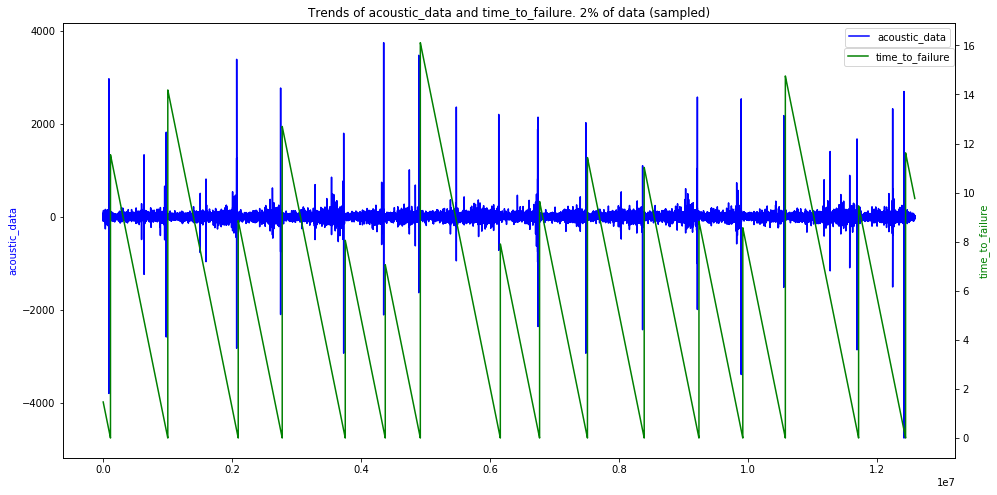

In [7]:
train_acoustic_data_small = train['acoustic_data'].values[::50]
train_time_to_failure_small = train['time_to_failure'].values[::50]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. 2% of data (sampled)")
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small

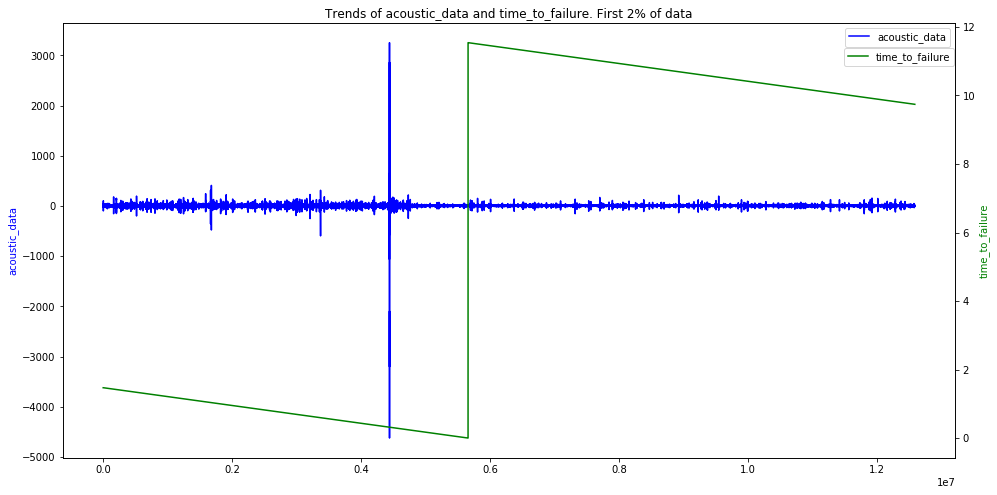

In [8]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. First 2% of data")
plt.plot(train['acoustic_data'].values[:12582910], color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train['time_to_failure'].values[:12582910], color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

On the first plot you can see 2% of all data (all data skipping each 50 rows). We can see that usually acoustic data shows huge fluctuations just before the failure and the nature of data is cyclical.

On the second plot we see first 2% of the data. It seems that at first the signal has huge fluctuations for a short time, then it lowers and after some time the earthquake occurs. I think it will be quite diffucult to distinguish target values properly

### Feature engineering

Let's create some new features.

Why 150000? Test segments are 150000 each. At first I create features similar to baseline kernel, but with more aggregations.

In [9]:
def add_areas(df_segment, dx=2.5e-07):
    '''calculates auc upto every point in a segment of acoustic data
    returns an array containing auc upto that point in array sequence
    '''
    x = df_segment['acoustic_data'].values
    x_shifted = np.zeros_like(x)
    x_shifted[1:] = x[:-1]
    x_stacked = np.stack((x_shifted, x), axis=-1)
    area_pairs = np.trapz(x_stacked, dx=dx)
    area_pairs.shape
    result = np.cumsum(area_pairs)
    return result


def tail_sizer(big_tail_factor=3, small_tail_factor=15, rows=rows):
    '''determines what factor or portion of total items forms the tails
    '''
    big_tail = rows // big_tail_factor
    small_tail = rows // small_tail_factor
    tails = [big_tail, small_tail]
    return tails

In [10]:
def classic_sta_lta_mean(x, length_sta, length_lta):    
    sta = np.cumsum(x ** 2)    
    # Convert to float
    sta = np.require(sta, dtype=np.float)    
    # Copy for LTA
    lta = sta.copy()    
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta    
    # Pad zeros
    sta[:length_lta - 1] = 0    
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return np.mean(sta / lta)

def sta_lta_func_maker(calculate_vals = False):
    sta_lta_len_pairs = [
                        (500, 10000),
                        (5000, 100000),
                        (3333, 6666),
                        (10000, 25000),
                        (50, 1000),
                        (100, 5000),
                        (333, 666),
                        (4000, 10000),
                        ]
    result = {}
    for i, sta_lta in enumerate(sta_lta_len_pairs):
        result[f'classic_sta_lta{i+1}_mean'] = partial(classic_sta_lta_mean, 
                                                      length_sta = sta_lta[0],
                                                      length_lta = sta_lta[1],
                                                      )
    if not calculate_vals:
        return list(result.keys())
    return result

In [11]:
def MA_func_maker(x = 0, calculate_vals = True):
    no_of_std = 3
    x = pd.Series(x)
    result = {}
    result['MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    Moving_average_700_mean = x.rolling(window=700).mean().mean(skipna=True)
    result['MA_700MA_BB_high_mean'] = (Moving_average_700_mean
                                      + no_of_std * result['MA_700MA_std_mean'])
    result['MA_700MA_BB_low_mean'] = (Moving_average_700_mean
                                      - no_of_std * result['MA_700MA_std_mean'])
    result['MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    #wtf arent these bottom ones wrong
    result['MA_400MA_BB_high_mean'] = (Moving_average_700_mean
                                      + no_of_std * result['MA_400MA_std_mean'])
    result['MA_400MA_BB_low_mean'] = (Moving_average_700_mean
                                      - no_of_std * result['MA_400MA_std_mean'])
    result['MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    if not calculate_vals:
        return list(result.keys())
    return result

In [12]:
def rolling_func_maker(x = 0, calculate_vals = True):
    windows = [10, 100, 1000]
    x = pd.Series(x)
    result = {}
    for window in windows:
        x_roll_std = x.rolling(window).std().dropna().values
        x_roll_mean = x.rolling(window).mean().dropna().values
        temp = {
                'std': x_roll_std,
                'mean': x_roll_mean,
                }
        if not calculate_vals:
            temp = {k: np.array([0]) for k in temp}
        for k, v in temp.items():
            result[f'ave_roll_{k}_{window}'] = v.mean()
            result[f'std_roll_{k}_{window}'] = v.std()
            result[f'max_roll_{k}_{window}'] = v.max()
            result[f'min_roll_{k}_{window}'] = v.min()
            result[f'q01_roll_{k}_{window}'] = np.quantile(v, 0.01)
            result[f'q05_roll_{k}_{window}'] = np.quantile(v, 0.05)
            result[f'q95_roll_{k}_{window}'] = np.quantile(v, 0.95)
            result[f'q99_roll_{k}_{window}'] = np.quantile(v, 0.99)
            result[f'av_change_abs_roll_{k}_{window}'] = np.mean(np.diff(v))
            result[f'av_change_abs_roll_{k}_{window}'] = np.mean(np.nonzero(
                                                                            (np.diff(v) / v[:-1])
                                                                            )[0])
    if not calculate_vals:
        return list(result.keys())
    return result

In [13]:
def column_namer(prefix=''):
    '''
    basic columns: passed as is
    columns: modified to make special cols
    based on heads and tails in aggregation
    prefix: what to add to column names for every new feature
    returns: list of basic columns, columns, and special columns.
    '''
    prefix = prefix.lower()
    if prefix == '':
        basic_columns = [
                'av_change_abs',
                'av_change_rate',
                'abs_max',
#                'abs_min',
                #new additions
                'abs_mean',
                'abs_std',
                'max_to_min',
                'max_to_min_diff',
                'count_big',
                'sum',
                'q99',
                'q95',
                'q5',
                'q1',
                'abs_q99',
                'abs_q95',
                'abs_q5',
                'abs_q1',
                'trend',
                'abs_trend',
                'mad',
                'kurt',
                'skew',
                'median',
                'Hilbert_mean',
                'Hann_window_mean',
                'exp_Moving_average_300_mean',
                'exp_Moving_average_3000_mean',
                'exp_Moving_average_30000_mean',
                ]
        columns = [
                    'avg',
                    'std',
                    'max',
                    'min',
                    'zscore_counts',
                    'zscore_sum',
                    ]

    if prefix == "on_auc":
        basic_columns = [
                'av_change_abs',
                'av_change_rate',
                'abs_max',
                'abs_min',
                ]
        columns = [
                    'avg',
                    'std',
                    'max',
                    'min',
#                    'zscore_counts',
#                    'zscore_sum',
                    ]
    sta_lta_cols = sta_lta_func_maker()
    
    basic_columns += sta_lta_cols #can be changed as needed
    if prefix:
        basic_columns = [f"{prefix}_{col}" for col in basic_columns]
        columns = [f"{prefix}_{col}" for col in columns]

    tails = tail_sizer()
    special_cols = []
    for col in columns:
        for tail in tails:
            special_cols.append(f'{col}_first_{tail}')
            special_cols.append(f'{col}_last_{tail}')
    
    MA_cols = MA_func_maker(calculate_vals = False)
    rolling_cols = rolling_func_maker(calculate_vals = False)
    return basic_columns, columns, special_cols, MA_cols, rolling_cols

In [14]:
def compute(x, prefix, rows=rows, z_score_cutoff=4):
    '''Takes a numpy array of a dataframe segment to
    aggregate into a single row as dict
    '''
    basic_columns, columns, special_cols, MA_cols, rolling_cols = column_namer(prefix)
    #calculations needed
    assert len(x) == rows

    def f_zscore_counts(x, z_score_cutoff=z_score_cutoff):
        zscore_seg = np.abs(stats.zscore(x))
        return np.sum(zscore_seg > z_score_cutoff)

    def f_zscore_sum(x, z_score_cutoff=z_score_cutoff):
        zscore_seg = np.abs(stats.zscore(x))
        return np.sum(zscore_seg[zscore_seg > z_score_cutoff])
    
    def calc_change_rate(x):
        change = (np.diff(x) / x[:-1])
        change = change[np.nonzero(change)[0]]
        change = change[~np.isnan(change)]
        change = change[change != -np.inf]
        change = change[change != np.inf]
        return np.mean(change)
    
    def add_trend_feature(arr, abs_values=False):
        idx = np.array(range(len(arr)))
        if abs_values:
            arr = np.abs(arr)
        lr = LinearRegression()
        lr.fit(idx.reshape(-1, 1), arr)
        return lr.coef_[0]
    
    ewma = pd.Series.ewm
    
    mapping = {
        'avg': lambda x: x.mean(),
        'std': lambda x: x.std(),
        'max': lambda x: x.max(),
        'min': lambda x: x.min(),
        'av_change_abs': lambda x: np.mean(np.diff(x)),
        'av_change_rate': calc_change_rate, #modified
        'abs_max': lambda x: np.abs(x).max(),
        'abs_min': lambda x: np.abs(x).min(),
        'abs_mean': lambda x: np.abs(x).mean(), #new
        'abs_std': lambda x: np.abs(x).std(), #new
        'zscore_counts': f_zscore_counts,
        'zscore_sum': f_zscore_sum,
        #new additions
        'max_to_min': lambda x: x.max() / np.abs(x.min()),
        'max_to_min_diff': lambda x: x.max() - np.abs(x.min()),
        'count_big': lambda x: len(x[np.abs(x) > 500]),
        'sum': lambda x: x.sum(),
        'q99': lambda x: np.quantile(x, 0.99),
        'q95': lambda x: np.quantile(x, 0.95),
        'q5': lambda x: np.quantile(x, 0.05),
        'q1': lambda x: np.quantile(x, 0.01),
        'abs_q99': lambda x: np.quantile(np.abs(x), 0.99),
        'abs_q95': lambda x: np.quantile(np.abs(x), 0.95),
        'abs_q5': lambda x: np.quantile(np.abs(x), 0.05),
        'abs_q1': lambda x: np.quantile(np.abs(x), 0.01),
        'trend': lambda x: add_trend_feature(x),
        'abs_trend': lambda x: add_trend_feature(x, abs_values=True),
        'mad': lambda x: pd.Series(x).mad(),
        'kurt': lambda x: pd.Series(x).kurtosis(),
        'skew': lambda x: pd.Series(x).skew(),
        'median': lambda x: np.median(x),
        'Hilbert_mean': lambda x: np.abs(hilbert(x)).mean(),
        'Hann_window_mean': lambda x: (convolve(x, hann(150), mode='same') / sum(hann(150))).mean(),
        'Moving_average_700_mean': lambda x: x.rolling(window=700).mean().mean(skipna=True),
        'exp_Moving_average_300_mean': lambda x: (ewma(pd.Series(x), span=300).mean()).mean(skipna = True),
        'exp_Moving_average_3000_mean': lambda x: (ewma(pd.Series(x), span=3000).mean()).mean(skipna = True),
        'exp_Moving_average_30000_mean': lambda x: (ewma(pd.Series(x), span=30000).mean()).mean(skipna = True),
        'iqr': lambda x: np.subtract(*np.percentile(x, [75, 25])),
        'q999': lambda x: np.quantile(x,0.999),
        'q001': lambda x: np.quantile(x,0.001),
        'ave10': lambda x: stats.trim_mean(x, 0.1),
        
        }
    sta_lta_mappings = sta_lta_func_maker(calculate_vals=True)
    mapping.update(sta_lta_mappings)
    
    if prefix:
        mapping = {f"{prefix}_{k}": v for k, v in mapping.items()}

    result = {k: mapping[k](x) for k in basic_columns + columns}
    
    if MA_cols:
        MA_results = MA_func_maker(x)
        result.update(MA_results)
    
    if rolling_cols:
        rolling_results = rolling_func_maker(x)
        result.update(rolling_results)
        
    tails = tail_sizer()

    for col in columns:
        for tail in tails:
            result[f'{col}_first_{tail}'] = mapping[col](x[: tail])
            result[f'{col}_last_{tail}'] = mapping[col](x[-tail:])
    return result




In [15]:
def feature_aggregation(calculate_vals=False, df_segment=None):
    '''Takes a dataframe segment, and returns column names if vals is false,
    otherwise returns the dict of results on which to update df
    '''
    #prefixes = ['', 'on_auc']
    prefixes = ['']
    all_cols = [list(chain.from_iterable(column_namer(prefix)))
                for prefix in prefixes]
    all_cols = list(chain.from_iterable(all_cols))
    if not calculate_vals:
        return all_cols

    result_dict = {}
    for prefix in prefixes:
        if prefix == '':
            x = df_segment['acoustic_data'].values
        elif prefix == 'on_auc':
            x = add_areas(df_segment)
        result_dict.update(compute(x, prefix))
    return result_dict

In [16]:
segments = int(np.floor(train.shape[0] / rows))
subsampling_size = 2
offset = int(np.floor((train.shape[0] - (rows// subsampling_size)) / rows))
segments += offset
print(segments)

8387


In [17]:
# Create a training file with simple derived features
X_tr = pd.DataFrame(index=range(segments), dtype=np.float64,
                    columns=feature_aggregation()
                   )
y_tr = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])

total_mean = train['acoustic_data'].mean()
total_std = train['acoustic_data'].std()
total_max = train['acoustic_data'].max()
total_min = train['acoustic_data'].min()
total_sum = train['acoustic_data'].sum()
total_abs_max = np.abs(train['acoustic_data']).sum()

for segment in tqdm_notebook(range(segments)):
    seg = train.iloc[segment*(rows//subsampling_size):segment*(rows//subsampling_size)+rows]
    y = seg['time_to_failure'].values[-1]
    y_tr.loc[segment, 'time_to_failure'] = y
    
    result = feature_aggregation(calculate_vals = True, df_segment = seg)
    for k, v in result.items():
        X_tr.loc[segment, k] = v


In [18]:
X_tr.to_csv("X_tr.csv")
y_tr.to_csv("Y_tr.csv")

In [19]:
print(f'{X_tr.shape[0]} samples in new train data.')

8387 samples in new train data.


Let's see all new features

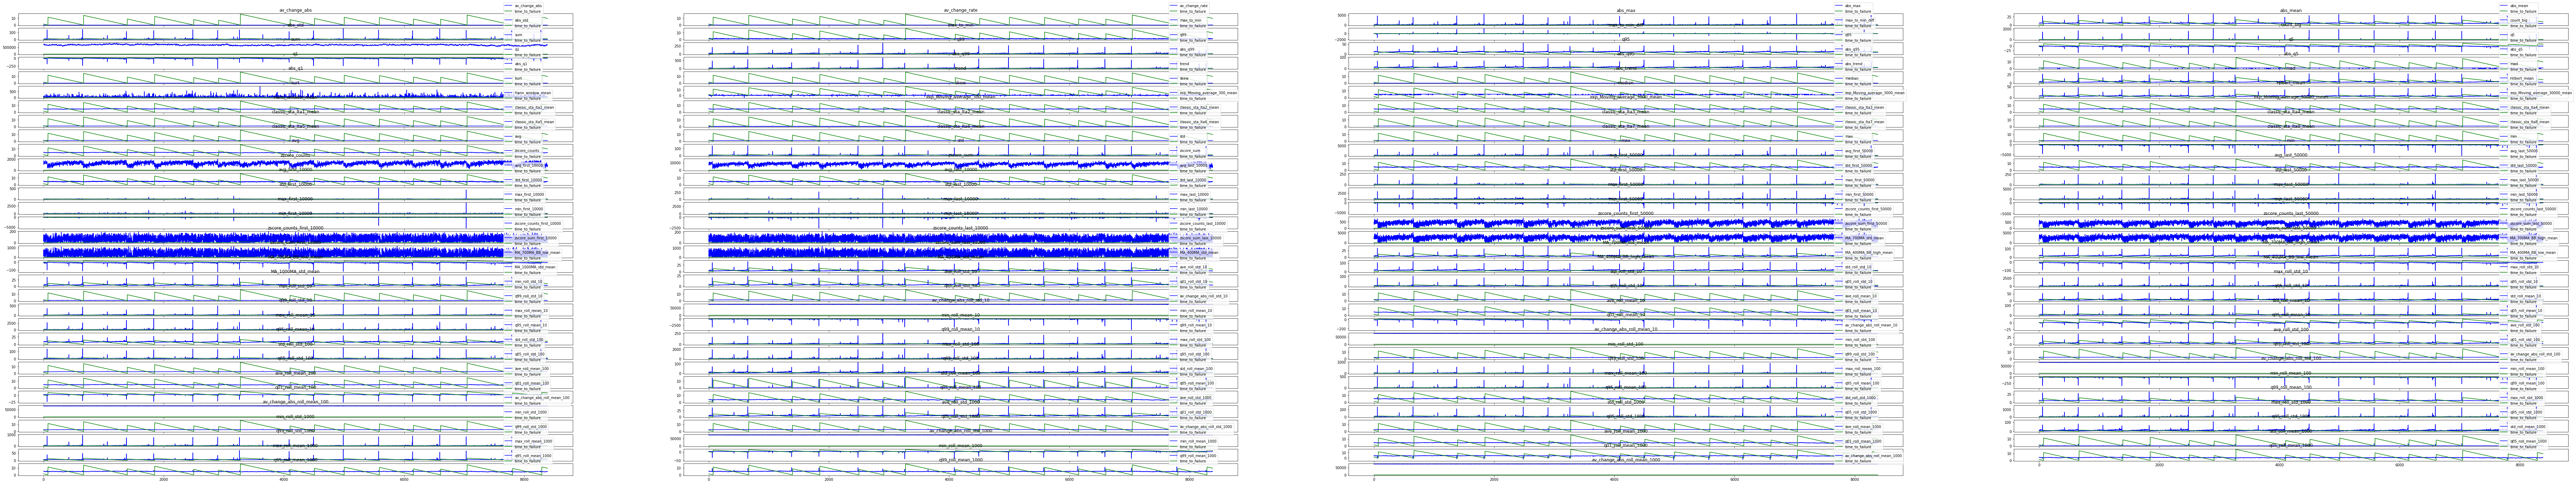

In [20]:
plt.figure(figsize=(len(X_tr.columns) + 2, 24))
for i, col in enumerate(X_tr.columns):
    plt.subplot(math.ceil(len(X_tr.columns)/4), 4, i + 1)
    plt.plot(X_tr[col], color='blue')
    plt.title(col)
    ax1.set_ylabel(col, color='b')
    # plt.legend([col])
    ax2 = ax1.twinx()
    plt.plot(y_tr, color='g')
    ax2.set_ylabel('time_to_failure', color='g')
    plt.legend([col, 'time_to_failure'], loc=(0.875, 0.9))
    plt.grid(False)

In [21]:
X_tr.dropna(how='any', axis = 0, inplace = True)

In [22]:
len(X_tr)

8373

In [23]:
X_tr.replace([np.inf, -np.inf], np.nan, inplace = True)

In [24]:
X_tr.dropna(how='any', axis = 0, inplace = True)

In [25]:
len(X_tr)

8335

In [26]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_train_scaled = pd.DataFrame(scaler.transform(X_tr), columns=X_tr.columns)

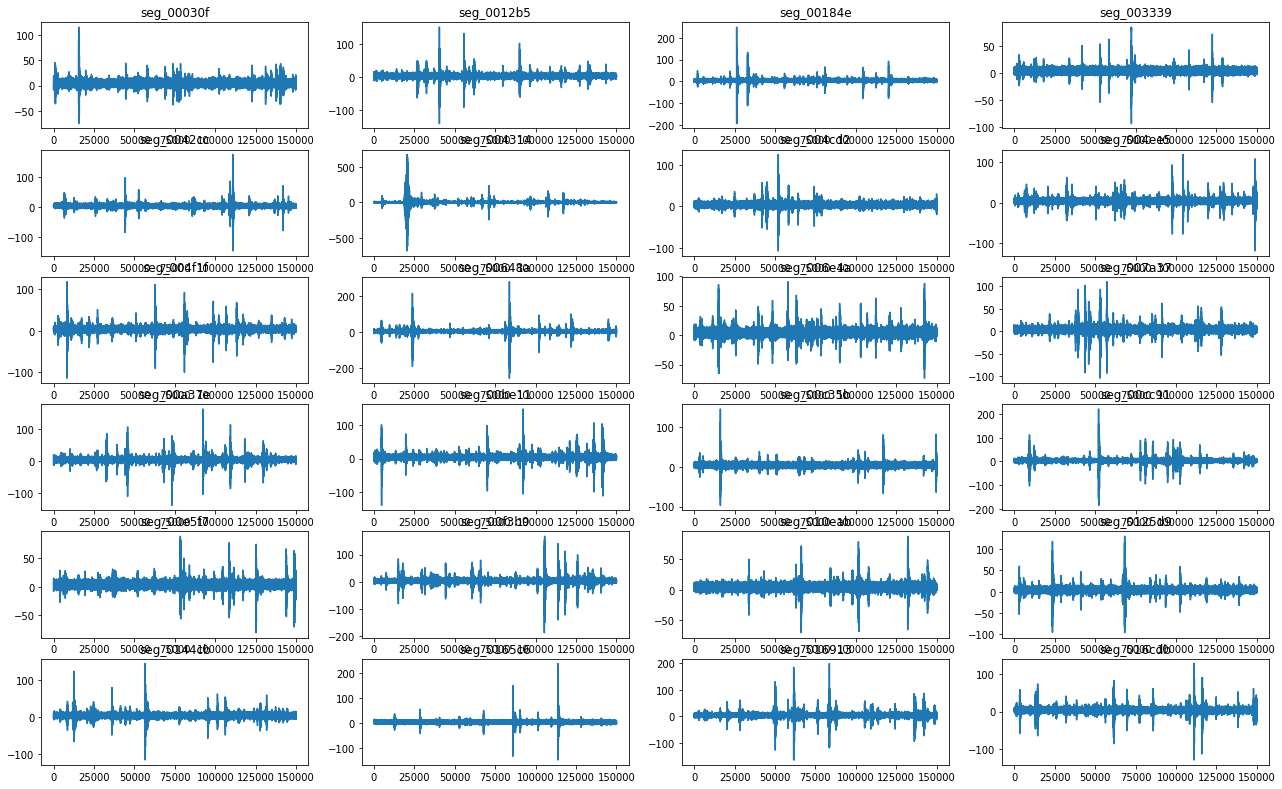

In [27]:
submission = pd.read_csv(root_folder + 'sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X_tr.columns, dtype=np.float64, index=submission.index)
plt.figure(figsize=(22, 16))

for i, seg_id in enumerate(tqdm_notebook(X_test.index)):
    seg = pd.read_csv(root_folder + 'test/' + seg_id + '.csv')
    
    result = feature_aggregation(calculate_vals = True, df_segment = seg)
    for k, v in result.items():
        X_test.loc[seg_id, k] = v
    
    if i < 24:
        plt.subplot(7, 4, i + 1)
        plt.plot(seg['acoustic_data'])
        plt.title(seg_id)
    
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [28]:
X_test.describe()

,av_change_abs,av_change_rate,abs_max,abs_mean,abs_std,max_to_min,max_to_min_diff,count_big,sum,q99,q95,q5,q1,abs_q99,abs_q95,abs_q5,abs_q1,trend,abs_trend,mad,kurt,skew,median,Hilbert_mean,Hann_window_mean,exp_Moving_average_300_mean,exp_Moving_average_3000_mean,exp_Moving_average_30000_mean,classic_sta_lta1_mean,classic_sta_lta2_mean,classic_sta_lta3_mean,classic_sta_lta4_mean,classic_sta_lta5_mean,classic_sta_lta6_mean,classic_sta_lta7_mean,classic_sta_lta8_mean,avg,std,max,min,...,q05_roll_mean_10,q95_roll_mean_10,q99_roll_mean_10,av_change_abs_roll_mean_10,ave_roll_std_100,std_roll_std_100,max_roll_std_100,min_roll_std_100,q01_roll_std_100,q05_roll_std_100,q95_roll_std_100,q99_roll_std_100,av_change_abs_roll_std_100,ave_roll_mean_100,std_roll_mean_100,max_roll_mean_100,min_roll_mean_100,q01_roll_mean_100,q05_roll_mean_100,q95_roll_mean_100,q99_roll_mean_100,av_change_abs_roll_mean_100,ave_roll_std_1000,std_roll_std_1000,max_roll_std_1000,min_roll_std_1000,q01_roll_std_1000,q05_roll_std_1000,q95_roll_std_1000,q99_roll_std_1000,av_change_abs_roll_std_1000,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000
count,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.00000000000000,2624.000000000000000,2624.000000000000000,2624.0,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,...,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000,2624.000000000000000
mean,0.000001465965058,-0.014968564631718,173.052591463414643,5.308058424796745,5.840771758232552,1.136905791265660,11.583841463414634,7.151295731707317,622292.335365853621624,20.429184451219577,10.998856707317072,-2.692073170731707,-12.083951981707310,25.55498475609766,11.971493902439006,0.548399390243902,0.0,-0.000000053238093,-0.000001529010572,3.542769394780283,68.561663296226641,0.118640555472581,4.075457317073170,7.006740463218129,4.148006119629682,4.148609435320050,4.148666785953431,4.149237417385622,0.957197128459380,0.332284896777699,0.952574016026791,0.832400580611710,1.031123302681449,1.026633228430451,0.988678721670399,0.932048599977619,4.148615569105695,6.684138336429662,165.683689024390247,-154.099847560975604,...,0.710766006097561,7.587480945121947,13.834725609756116,74995.887938946456416,4.405064272414341,4.836394907460423,78.521479228184475,1.952905622508490,2.303907511902224,2.472864917190421,9.959646800662320,26.204938723419655,74954.864471938519273,4.148622050817760,0.545631271565747,13.861036585365868,-5.138795731707308,2.9220464939

In [29]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [30]:
def train_model(X=X_train_scaled, X_test=X_test_scaled, y=y_tr, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=10000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_tr.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_tr.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
            
        if model_type == 'rcv':
            model = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_absolute_error', cv=3)
            model.fit(X_train, y_train)
            print(model.alpha_)

            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

Fold 0 started at Thu Mar 14 15:14:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1641]	training's l1: 1.68349	valid_1's l1: 2.23454
Fold 1 started at Thu Mar 14 15:14:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1876]	training's l1: 1.59249	valid_1's l1: 2.33197
Fold 2 started at Thu Mar 14 15:15:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1402]	training's l1: 1.75583	valid_1's l1: 2.2932
Fold 3 started at Thu Mar 14 15:16:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2211]	training's l1: 1.49161	valid_1's l1: 2.28805
Fold 4 started at Thu Mar 14 15:16:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1923]	training's l1: 1.58381	valid_1's l1: 2.28937
CV mean score: 2.2874, std: 0.0310.


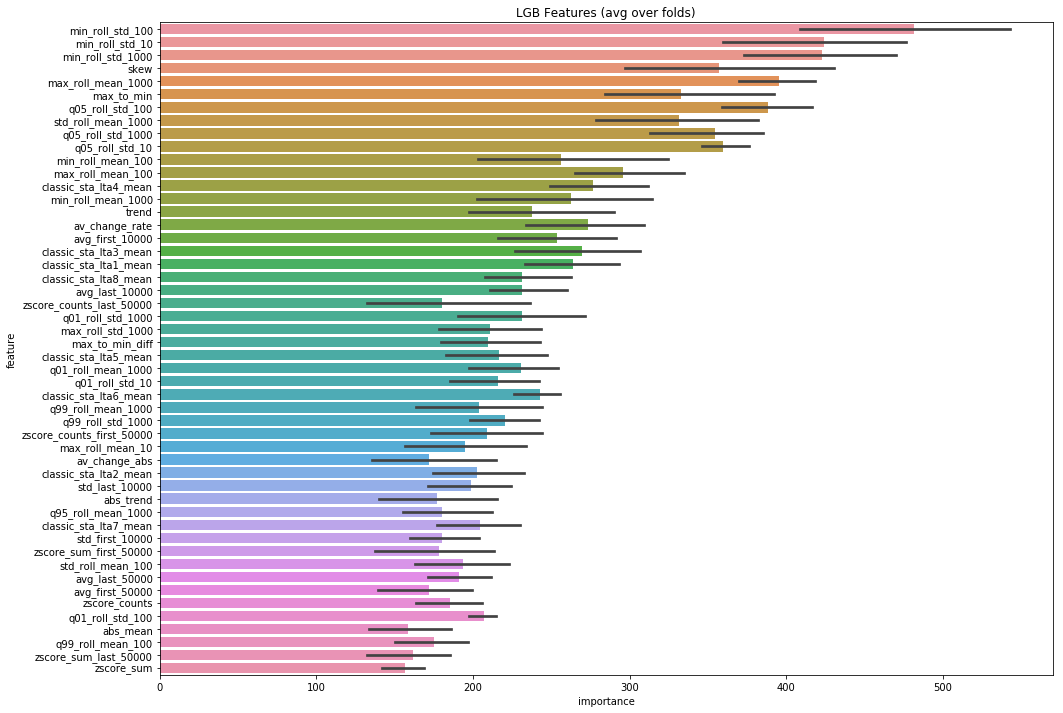

In [31]:
params = {'num_leaves': 54,
         'min_data_in_leaf': 79,
         'objective': 'huber',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         # "feature_fraction": 0.8354507676881442,
         "bagging_freq": 3,
         "bagging_fraction": 0.8126672064208567,
         "bagging_seed": 11,
         "metric": 'mae',
         "verbosity": -1,
         'reg_alpha': 1.1302650970728192,
         'reg_lambda': 0.3603427518866501
         }
oof_lgb, prediction_lgb, feature_importance = train_model(params=params, model_type='lgb', plot_feature_importance=True)

In [32]:
xgb_params = {'eta': 0.04, 'max_depth': 10, 'subsample': 0.9, #'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'mae', 'silent': True, 'nthread': 4}
oof_xgb, prediction_xgb = train_model(params=xgb_params, model_type='xgb')

Fold 0 started at Thu Mar 14 15:17:31 2019
[0]	train-mae:4.98677	valid_data-mae:5.03208
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
[500]	train-mae:0.082353	valid_data-mae:2.28594
[1000]	train-mae:0.005225	valid_data-mae:2.28449
[1500]	train-mae:0.000453	valid_data-mae:2.28443
Stopping. Best iteration:
[1617]	train-mae:0.000408	valid_data-mae:2.28442

Fold 1 started at Thu Mar 14 15:20:38 2019
[0]	train-mae:4.97627	valid_data-mae:5.06886
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
[500]	train-mae:0.079445	valid_data-mae:2.34046
[1000]	train-mae:0.005134	valid_data-mae:2.3392
Stopping. Best iteration:
[1233]	train-mae:0.001576	valid_data-mae:2.33913

Fold 2 started at Thu Mar 14 15:23:33 2019
[0]	train-mae:5.01075	valid_data-mae:4.92825
Multiple eval metrics have been pa

In [33]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2624 entries, seg_00030f to seg_ffe7cc
Columns: 127 entries, av_change_abs to av_change_abs_roll_mean_1000
dtypes: float64(127)
memory usage: 2.6+ MB


In [34]:
model = NuSVR(gamma='scale', nu=0.7, C=10.0)
oof_svr, prediction_svr = train_model(params=None, model_type='sklearn', model=model)

Fold 0 started at Thu Mar 14 15:32:49 2019
Fold 0. MAE: 2.3087.

Fold 1 started at Thu Mar 14 15:33:05 2019
Fold 1. MAE: 2.3825.

Fold 2 started at Thu Mar 14 15:33:20 2019
Fold 2. MAE: 2.3469.

Fold 3 started at Thu Mar 14 15:33:34 2019
Fold 3. MAE: 2.3962.

Fold 4 started at Thu Mar 14 15:33:49 2019
Fold 4. MAE: 2.3307.

CV mean score: 2.3530, std: 0.0323.


Interestingly, if we compare the results of training on this data with results of training on smaller dataset (as in official baseline), then we can see that MAE for XGB model became less than MAE of LGB model.

Now let's see how do our models perform

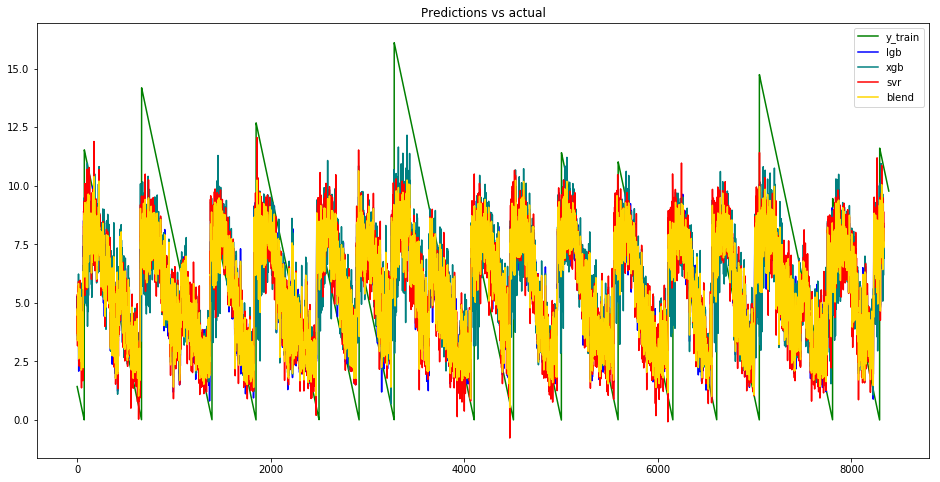

In [35]:
plt.figure(figsize=(16, 8))
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_lgb, color='b', label='lgb')
plt.plot(oof_xgb, color='teal', label='xgb')
plt.plot(oof_svr, color='red', label='svr')
plt.plot((oof_lgb + oof_xgb + oof_svr) / 3, color='gold', label='blend')
plt.legend();
plt.title('Predictions vs actual');

We can see that models can't predict high values well, but additional data is predicted much better.

In [36]:
prediction_lgb[:10], prediction_xgb[:10], prediction_svr[:10]

(array([3.16480395, 5.82803323, 5.78310966, 8.59684976, 7.02611349,
        3.14895979, 8.10659206, 4.90883391, 5.38369381, 3.52930279]),
 array([3.49729743, 6.9259656 , 5.57580748, 8.78019581, 7.71503687,
        3.71559572, 9.19483299, 5.26420946, 5.28784084, 3.60767055]),
 array([3.97783639, 6.55988831, 5.66038583, 8.38001706, 7.96747141,
        2.85341486, 8.34479167, 5.4643004 , 6.053909  , 2.8889209 ]))

In [37]:
submission['time_to_failure'] = (prediction_lgb + prediction_xgb + prediction_svr) / 3
print(submission.head())
submission.to_csv('submission.csv')

              time_to_failure
seg_id                       
seg_00030f  3.546645924568594
seg_0012b5  6.437962378953473
seg_00184e  5.673100988999764
seg_003339  8.585687543562832
seg_0042cc  7.569540587065156
